## Etapa 3 - Treinamento do modelo base

O objetivo desta etapa é treinar um modelo base de classificação de faixa etária utilizando uma arquitetura pré-treinada e, utilizar o dataset já carregado do notebook anterior.
A arquitetura utilizada neste modelo será a MobileNet, uma CNN leve e eficiente. As motivações para escolha desta arquitetura base são:

- Rede leve, eficiente e já pré-treinada com ImageNet (já vem com os pesos do ImageNet), acelerando o processo de fine-tuning, permitindo então que o modelo aprenda mais rapidamente.
- Bem integrada na API do tensorflow.keras.applications, com funções prontas como:
	•	preprocess_input()
	•	decode_predictions() (para testes)
- Pouco tempo para treinamento

Outras arquiteturas serão utilizadas na etapa seguinte, de experimentação com o treinamento de outros modelos.


**OBS:
Algumas etapas de pré-processamento de imagem (como redimensionamento e normalização) foram deixadas para este notebook, pois essas transformações variam conforme a arquitetura utilizada. Portanto, a partir do momento que decidimos utilizar a MobileNetV2, uma normalização específica (via preprocess_input ) é exigida, por exemplo.


<!-- TEXTO SUGERIDO -->
Para a construção do modelo base, foi utilizada a arquitetura MobileNetV2, uma rede convolucional leve e eficiente, amplamente utilizada em tarefas de visão computacional com restrições de tempo e recursos computacionais. A MobileNetV2 foi carregada com pesos pré-treinados no ImageNet e teve suas camadas congeladas, de modo a preservar os filtros previamente aprendidos.

Sobre a arquitetura final, foi adicionada uma camada de Global Average Pooling, seguida de uma camada totalmente conectada com 128 neurônios e ativação ReLU, e uma camada de Dropout (0.5) para regularização. Por fim, uma camada Dense com ativação softmax foi usada para classificar entre as 7 faixas etárias previstas no dataset.

A escolha da MobileNetV2 se deu pelo seu baixo custo computacional, facilidade de integração com Keras, e bom desempenho em tarefas de classificação de imagens reais, como rostos humanos, o que a torna ideal para estabelecer um modelo de referência (baseline) no início do projeto.

In [65]:
# Importação das bibliotecas

import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# MobileNetV2: já com pré-treinamento ImageNet integrado
from tensorflow.keras.applications import MobileNetV2

In [66]:
# Definição do caminho para os dados e parâmetros do modelo
DATA_DIR = "../data/FairFace"
LABELS_PATH = os.path.join(DATA_DIR, "df_processado.csv")
WEIGHTS_PATH = "../weights/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5"

IMG_SIZE = (224, 224) # Tamanho exigido pela ImageNet
BATCH_SIZE = 32 # Quantas imagens serão processadas por vez

# Lendo dados processados (pelo notebook anterior, de pre processamento)

In [67]:
# Leitura dos dados processados
print("Lendo DataFrame com rótulos numéricos...")
df = pd.read_csv(LABELS_PATH)

# Conversão obrigatória dos rótulos para string
df['label'] = df['label'].astype(str)
print("DataFrame com rótulos numéricos convertidos para string: ", df['label'].unique())

NUM_CLASSES = df['label'].nunique()

Lendo DataFrame com rótulos numéricos...
DataFrame com rótulos numéricos convertidos para string:  ['6' '4' '3' '2' '5' '1' '7' '0' '8']


# Conversão dos rótulos em categorias

O modelo espera que os rótulos de faixa etária estejam em formato categórico, então o ImageDataGenerator faz essa conversão ao usar class_mode='categorical'.

# Normalização de pixels

As imagens devem ter os pixels normalizados e, como estamos utilizando a arquitetura MobileNetV2, é exigida uma normalização específica com valores entre -1 e 1.
Para isso utiliza-se o parâmetro preprocessing_function=preprocess_input.

# Divisão entre treino e validação
Embora os dados baixados via Kaggle já estejam divididos entre treino (88%) e validação (12%) como visto na etapa de análise exploratória, contudo é uma boa prática de desenvolvimento re-dividir o conjunto de treinamento para fazer validação interna.
A ideia é testar o modelo final utilizando o conjunto de validação (não utilizado agora) como uma validação final.

Para fazer a divisão de forma automática e rápida, o ImageDataGenerator também permite com o parâmetro validation_split.

In [68]:
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.1
)

# Redimensionamento de imagem

É importante garantir que todas as imagens estejam padronizadas no tamanho de entrada, portanto é importante redimensioná-las para um tamanho fixo. 
O tamanho de 224x224 pixels é comum para redes pré-treinadas. Este valor já foi definido anteriormente através da variável IMG_SIZE.

In [69]:
train_gen = datagen.flow_from_dataframe(
    dataframe=df,
    directory=DATA_DIR,
    x_col='file',
    y_col='label',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    subset='training',
    seed=42
)

val_gen = datagen.flow_from_dataframe(
    dataframe=df,
    directory=DATA_DIR,
    x_col='file',
    y_col='label',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    subset='validation',
    seed=42
)

Found 78070 validated image filenames belonging to 9 classes.
Found 8674 validated image filenames belonging to 9 classes.


# Visualização de imagens para validação visual

Esta não é uma etapa mandatória, porém é interessante visualizarmos as imagens após as etapas de normalização e redimensionamento pra validar que as mesmas estão sendo carregadas corretamente e as faixas etárias (que é classe a prever) está sendo mapeada de forma correta.


Obs: Se fizermos a visualização das imagens na escala [-1, 1], a visualização será muito ruim (as imagens ficarão escurecidas, avermelhadas e com menor definição), pois essa escala não é feita para visualização humana. Se quisermos a visualização humana, precisamos converter para [0, 1], como feito abaixo.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..0.79607844].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.6392157].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..0.79607844].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8901961..0.9607843].
Clipping input data to th

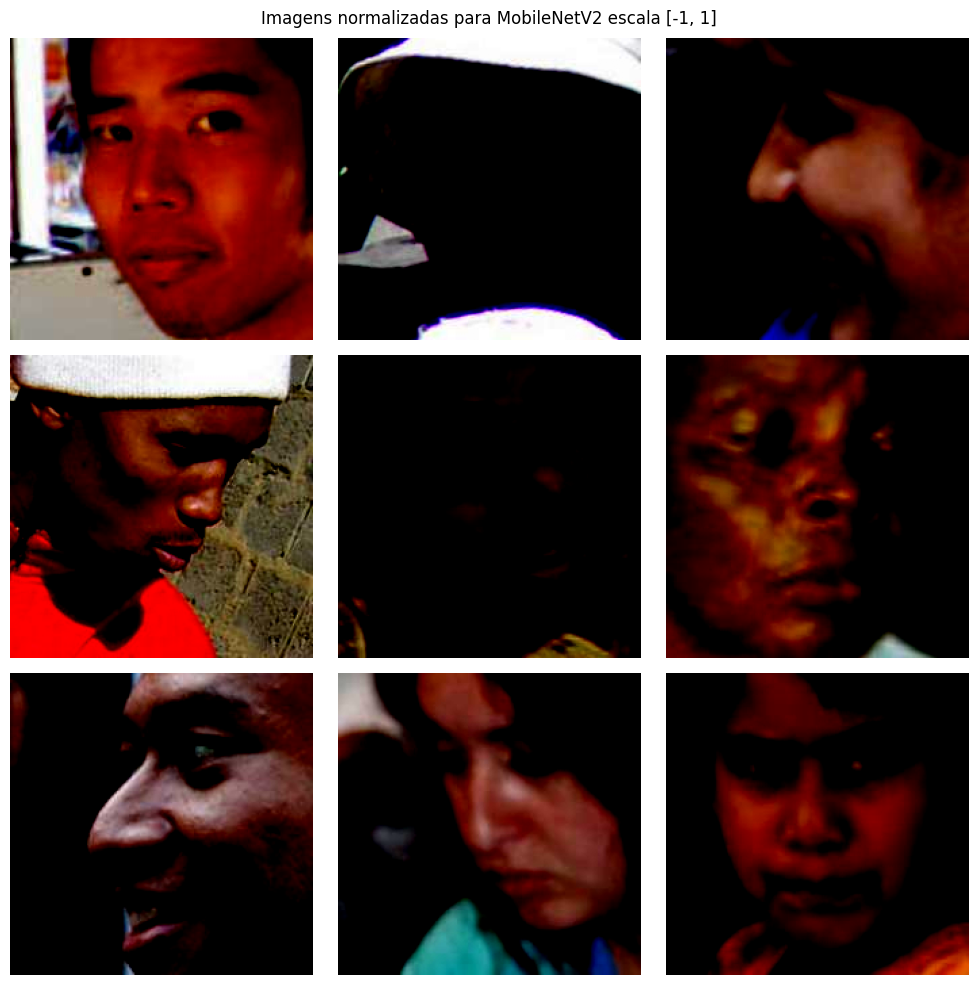

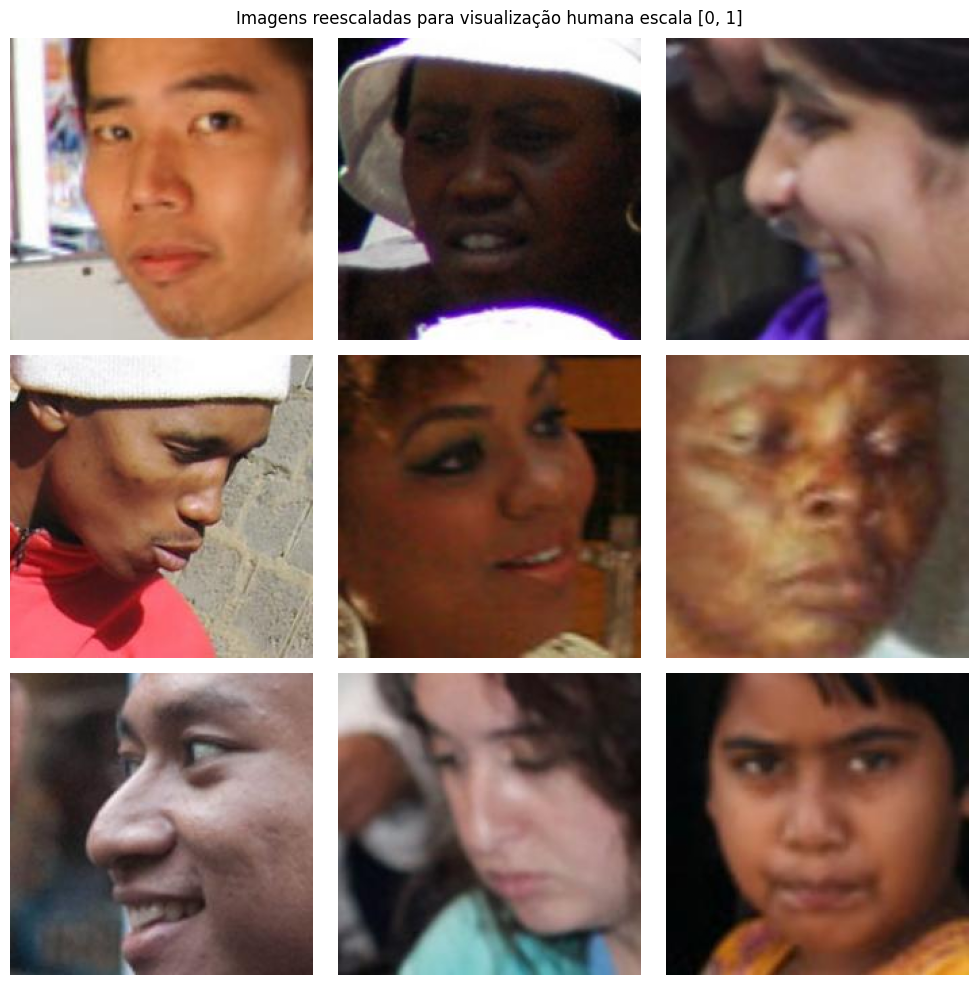

In [70]:
# Visualizar um batch de imagens do gerador de treino
def plot_images(images, title, n=9, preprocess=False):
    plt.figure(figsize=(10, 10))
    for i in range(n):
        img = images[i]
        if preprocess:
            img = (img + 1.0) / 2.0  # Reverte para [0, 1]
        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title, fontsize=12)
    plt.tight_layout()
    plt.show()

# Exibe diretamente o batch gerado por train_gen
images, labels = next(train_gen)

# Visualização das imagens
plot_images(images, "Imagens normalizadas para MobileNetV2 escala [-1, 1]")
plot_images(images, "Imagens reescaladas para visualização humana escala [0, 1]", preprocess=True)

# Construção do modelo com MobileNetV2

Carrega a MobileNetV2 pré-treinada no ImageNet, removendo sua cabeça de classificação (include_top=False).
O modelo base é congelado, ou seja, suas camadas não serão treinadas nesta etapa. Isso é feito para aproveitar os recursos já aprendidos sem alterar os pesos.

Esta etapa também define a arquitetura final:
- GlobalAveragePooling2D: reduz as saídas convolucionais para um vetor
- Dense(128) + Dropout: adiciona capacidade de classificação e regularização
- Dense(NUM_CLASSES, softmax): camada de saída com ativação para múltiplas classes

OBS: Os pesos ImageNet foram baixados via url:
https://storage.googleapis.com/tensorflow/keras-applications/mobilenet_v2/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5

In [71]:
# include_top=False: exclui as camadas de classificação do ImageNet
print("Construindo modelo base com MobileNetV2...")
base_model = MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights=WEIGHTS_PATH  # usando pesos locais
)
# Outra possibilidade seria utilizar weights='imagenet', porém os pesos foram baixados localmente e versionados

base_model.trainable = False  # congela as camadas do backbone

# GlobalAveragePooling2D: reduz o mapa de ativação para vetor
# Dropout: ajuda a evitar overfitting
# Dense(NUM_CLASSES): camada final de classificação
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

Construindo modelo base com MobileNetV2...


# Compilação do modelo

Configura o modelo para treinamento:
- Adam: otimizador robusto e adaptativo
- categorical_crossentropy: função de perda adequada para classificação multiclasse
- accuracy: métrica principal de avaliação

In [72]:
#	adam: otimizador padrão eficaz para esse tipo de tarefa
# categorical_crossentropy: adequado para classificação com one-hot encoding

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Treinamento do modelo

Inicia o treinamento do modelo por 5 épocas. Os dados são lidos em batches, e o desempenho é avaliado ao final de cada época com o conjunto de validação.

In [ ]:
EPOCHS = 5
print("Treinando modelo por", EPOCHS, "epocas...")

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)

# Visualização do histórico de treinamento

Gera gráficos de acurácia e perda ao longo das épocas, tanto para treino quanto para validação. Isso permite verificar se o modelo está aprendendo corretamente ou se há indícios de overfitting.

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia por época')
plt.xlabel('Epoca')
plt.ylabel('Acurácia')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Loss por época')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()